In [ ]:
# !pip install yfinance

In [ ]:
import yfinance as yf

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input

import math

import warnings
warnings.filterwarnings("ignore")

In [ ]:
ticker = 'TSLA'
data = yf.download(ticker, start='2000-01-01', end='2025-12-20')
data

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,
2010-06-29,1.592667,1.666667,1.169333,1.266667,281494500
2010-06-30,1.588667,2.028000,1.553333,1.719333,257806500
2010-07-01,1.464000,1.728000,1.351333,1.666667,123282000
2010-07-02,1.280000,1.540000,1.247333,1.533333,77097000
2010-07-06,1.074000,1.333333,1.055333,1.333333,103003500
...,...,...,...,...,...
2025-12-15,475.309998,481.769989,467.660004,469.440002,114542200
2025-12-16,489.880005,491.500000,465.829987,472.209991,107608100


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3895 entries, 2010-06-29 to 2025-12-19
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, TSLA)   3895 non-null   float64
 1   (High, TSLA)    3895 non-null   float64
 2   (Low, TSLA)     3895 non-null   float64
 3   (Open, TSLA)    3895 non-null   float64
 4   (Volume, TSLA)  3895 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 182.6 KB


In [ ]:
#data = data[['Close', 'Volume']]

print(data.isna().sum())

data = data.fillna(method='ffill')


Price   Ticker
Close   TSLA      0
High    TSLA      0
Low     TSLA      0
Open    TSLA      0
Volume  TSLA      0
dtype: int64


In [ ]:
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

print("Train shape:", train.shape)
print("Test shape:", test.shape)


Train shape: (3116, 5)
Test shape: (779, 5)


In [ ]:
test

Price,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,
2022-11-11,195.970001,196.520004,182.589996,186.000000,114403600
2022-11-14,190.949997,195.729996,186.339996,192.770004,92226600
2022-11-15,194.419998,200.820007,192.059998,195.880005,91293800
2022-11-16,186.919998,192.570007,185.660004,191.509995,66567600
2022-11-17,183.169998,186.160004,180.899994,183.960007,64336000
...,...,...,...,...,...
2025-12-15,475.309998,481.769989,467.660004,469.440002,114542200
2025-12-16,489.880005,491.500000,465.829987,472.209991,107608100


In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))

scaled_data_tr = scaler.fit_transform(train)
scaled_data_ts = scaler.transform(test)

def create_dataset(data, time_step=10):
    # data = data.values
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), :])
        y.append(data[i + time_step, :])
    return np.array(X), np.array(y)

X_train, y_train = create_dataset(scaled_data_tr)
X_test, y_test = create_dataset(scaled_data_ts)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3105, 10, 5), (768, 10, 5), (3105, 5), (768, 5))

In [ ]:
model = Sequential()
model.add(Input(shape=X_train.shape[1:]))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50, return_sequences=False))
# model.add(Dense(25))
model.add(Dense(5))

model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 10, 50)              │          11,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 5)                   │             255 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,655 (123.65 KB)

 Trainable params: 31,655 (123.65 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.fit(X_train, y_train, batch_size=64, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.0083 - val_loss: 0.0039
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0013 - val_loss: 0.0034
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0012 - val_loss: 0.0041
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0012 - val_loss: 0.0034
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0012 - val_loss: 0.0028
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0012 - val_loss: 0.0031
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0011 - val_loss: 0.0027
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0012 - val_loss: 0.0055
Epoch 9/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0011 - val_loss: 0.0026
Epoch 10/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0010 - val_loss: 0.0022


In [ ]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

rmse = math.sqrt(mean_squared_error(y_test, predictions))
print(f'RMSE: {rmse}')

mse =(mean_squared_error(y_test, predictions))
print(f'MSE: {mse}')

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
RMSE: 52105609.495724246
MSE: 2714994540920908.5


In [ ]:
predictions.shape

(768, 5)

In [ ]:
preds = predictions[:, 0]
preds

array([190.57648 , 189.71498 , 189.30492 , 189.52795 , 191.1456  ,
       193.20493 , 194.75935 , 195.66156 , 195.4779  , 193.95467 ,
       192.3572  , 190.57135 , 188.56677 , 185.24284 , 181.14534 ,
       177.24275 , 173.53056 , 169.50493 , 165.1691  , 160.39949 ,
       154.77405 , 148.61946 , 142.34142 , 137.42409 , 133.3731  ,
       129.66235 , 126.137764, 123.13939 , 120.46923 , 119.328766,
       119.12304 , 120.05619 , 121.186455, 121.70636 , 122.95769 ,
       125.35654 , 127.48111 , 129.55792 , 132.34418 , 135.08653 ,
       138.04005 , 142.23346 , 148.09053 , 154.7903  , 160.46945 ,
       166.19766 , 172.94968 , 179.48785 , 185.40941 , 190.87753 ,
       196.07559 , 201.0497  , 204.67065 , 206.95068 , 209.22223 ,
       211.75732 , 213.97942 , 215.53842 , 216.41422 , 216.4689  ,
       216.24722 , 214.98178 , 214.82375 , 215.49239 , 215.72449 ,
       214.18753 , 212.94247 , 211.80568 , 210.34833 , 208.2476  ,
       205.36342 , 202.15842 , 198.08543 , 194.7957  , 192.391

In [ ]:
preds.shape

(768,)

In [ ]:
p = np.concatenate([test.Close[:11].values.reshape((-1,)), preds])

In [ ]:
test["preds"] = p

In [ ]:
test

Price,Close,High,Low,Open,Volume,preds
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA,
Date,,,,,,
2022-11-11,195.970001,196.520004,182.589996,186.000000,114403600,195.970001
2022-11-14,190.949997,195.729996,186.339996,192.770004,92226600,190.949997
2022-11-15,194.419998,200.820007,192.059998,195.880005,91293800,194.419998
2022-11-16,186.919998,192.570007,185.660004,191.509995,66567600,186.919998
2022-11-17,183.169998,186.160004,180.899994,183.960007,64336000,183.169998
...,...,...,...,...,...,...
2025-12-15,475.309998,481.769989,467.660004,469.440002,114542200,420.820312
2025-12-16,489.880005,491.500000,465.829987,472.209991,107608100,422.134460


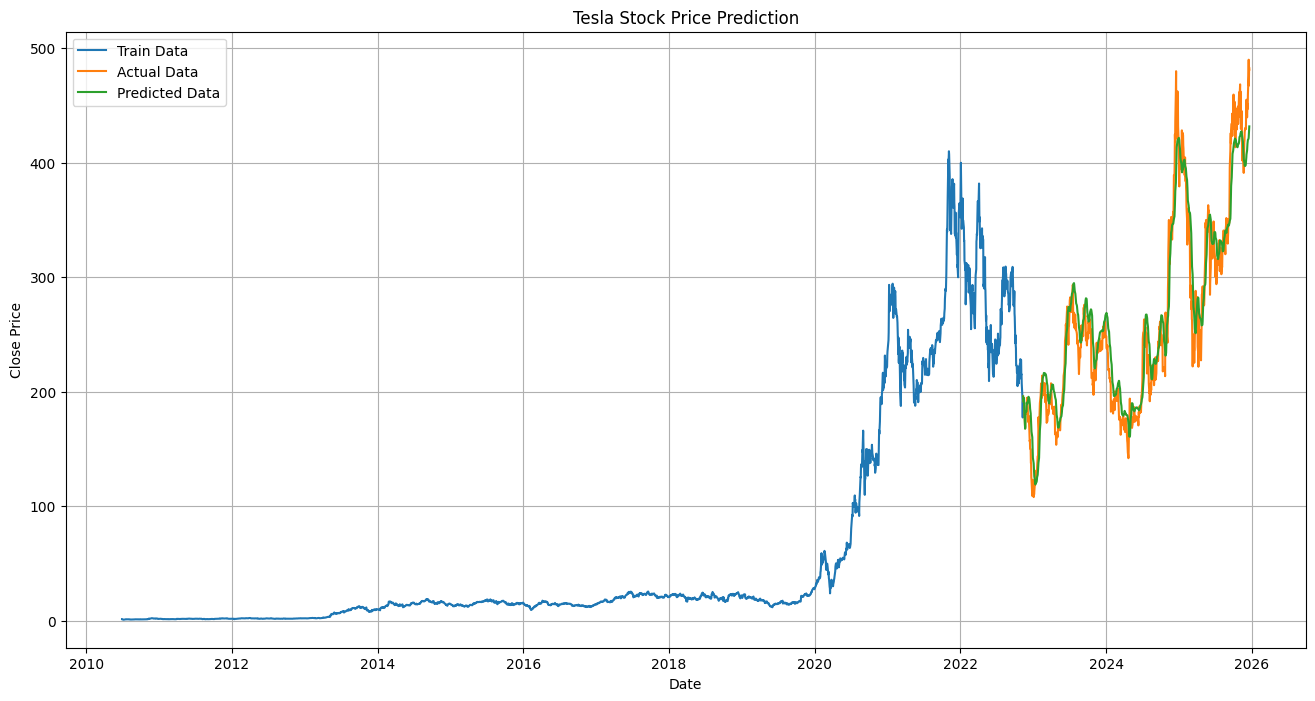

In [ ]:
plt.figure(figsize=(16, 8))
plt.title('Tesla Stock Price Prediction')
plt.plot(train['Close'], label='Train Data')
plt.plot(test['Close'], label='Actual Data')
plt.plot(test['preds'], label='Predicted Data')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid()
plt.legend()

## Predict new days

In [ ]:
test_pred = test.iloc[-10:, :-1]
test_pred.shape

(10, 5)

In [ ]:
test_pred

Price,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,
2025-12-08,439.579987,449.750000,435.250000,447.450012,69165800
2025-12-09,445.170013,452.390015,435.700012,437.540009,62367400
2025-12-10,451.450012,456.880005,443.609985,446.070007,63257500
2025-12-11,446.890015,449.269989,440.329987,448.950012,55979500
2025-12-12,458.959991,463.010010,441.670013,448.089996,95656700
2025-12-15,475.309998,481.769989,467.660004,469.440002,114542200
2025-12-16,489.880005,491.500000,465.829987,472.209991,107608100
2025-12-17,467.260010,495.279999,466.200012,488.220001,106490400


In [ ]:
test_pred.columns = ['Close', 'High', 'Low', 'Open', 'Volume']

In [ ]:
test_pred

,Close,High,Low,Open,Volume
Date,,,,,
2025-12-08,439.579987,449.750000,435.250000,447.450012,69165800
2025-12-09,445.170013,452.390015,435.700012,437.540009,62367400
2025-12-10,451.450012,456.880005,443.609985,446.070007,63257500
2025-12-11,446.890015,449.269989,440.329987,448.950012,55979500
2025-12-12,458.959991,463.010010,441.670013,448.089996,95656700
2025-12-15,475.309998,481.769989,467.660004,469.440002,114542200
2025-12-16,489.880005,491.500000,465.829987,472.209991,107608100
2025-12-17,467.260010,495.279999,466.200012,488.220001,106490400
2025-12-18,483.369995,490.859985,473.119995,478.160004,95168400


In [ ]:
for i in range(30):
    t = np.expand_dims(scaler.transform(test_pred), axis=0)
    p = scaler.inverse_transform(model.predict(t))
    d = test_pred.index[-1].day
    m = test_pred.index[-1].month
    y = test_pred.index[-1].year
    p_df = pd.DataFrame(p, columns=test_pred.columns, index=[pd.date_range(start=test_pred.index[-1], periods=2, freq='B')[-1]])

    test_pred = pd.concat([test_pred, p_df])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━

In [ ]:
test_pred

,Close,High,Low,Open,Volume
2025-12-08,439.579987,449.750000,435.250000,447.450012,6.916580e+07
2025-12-09,445.170013,452.390015,435.700012,437.540009,6.236740e+07
2025-12-10,451.450012,456.880005,443.609985,446.070007,6.325750e+07
2025-12-11,446.890015,449.269989,440.329987,448.950012,5.597950e+07
2025-12-12,458.959991,463.010010,441.670013,448.089996,9.565670e+07
2025-12-15,475.309998,481.769989,467.660004,469.440002,1.145422e+08
2025-12-16,489.880005,491.500000,465.829987,472.209991,1.076081e+08
2025-12-17,467.260010,495.279999,466.200012,488.220001,1.064904e+08
2025-12-18,483.369995,490.859985,473.119995,478.160004,9.516840e+07
2025-12-19,481.200012,490.489990,474.720001,488.119995,1.033054e+08


In [ ]:
ticker = 'TSLA'
data = yf.download(ticker, start='2025-12-08', end='2025-12-26')
data[-20:]

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,
2025-12-08,439.579987,449.750000,435.250000,447.450012,69165800
2025-12-09,445.170013,452.390015,435.700012,437.540009,62367400
2025-12-10,451.450012,456.880005,443.609985,446.070007,63257500
2025-12-11,446.890015,449.269989,440.329987,448.950012,55979500
2025-12-12,458.959991,463.010010,441.670013,448.089996,95656700
2025-12-15,475.309998,481.769989,467.660004,469.440002,114542200
2025-12-16,489.880005,491.500000,465.829987,472.209991,107608100
2025-12-17,467.260010,495.279999,466.200012,488.220001,106490400


In [ ]:
test_pred.iloc[:15]

,Close,High,Low,Open,Volume
2025-12-08,439.579987,449.750000,435.250000,447.450012,69165800.0
2025-12-09,445.170013,452.390015,435.700012,437.540009,62367400.0
2025-12-10,451.450012,456.880005,443.609985,446.070007,63257500.0
2025-12-11,446.890015,449.269989,440.329987,448.950012,55979500.0
2025-12-12,458.959991,463.010010,441.670013,448.089996,95656700.0
2025-12-15,475.309998,481.769989,467.660004,469.440002,114542200.0
2025-12-16,489.880005,491.500000,465.829987,472.209991,107608100.0
2025-12-17,467.260010,495.279999,466.200012,488.220001,106490400.0
2025-12-18,483.369995,490.859985,473.119995,478.160004,95168400.0
2025-12-19,481.200012,490.489990,474.720001,488.119995,103305400.0


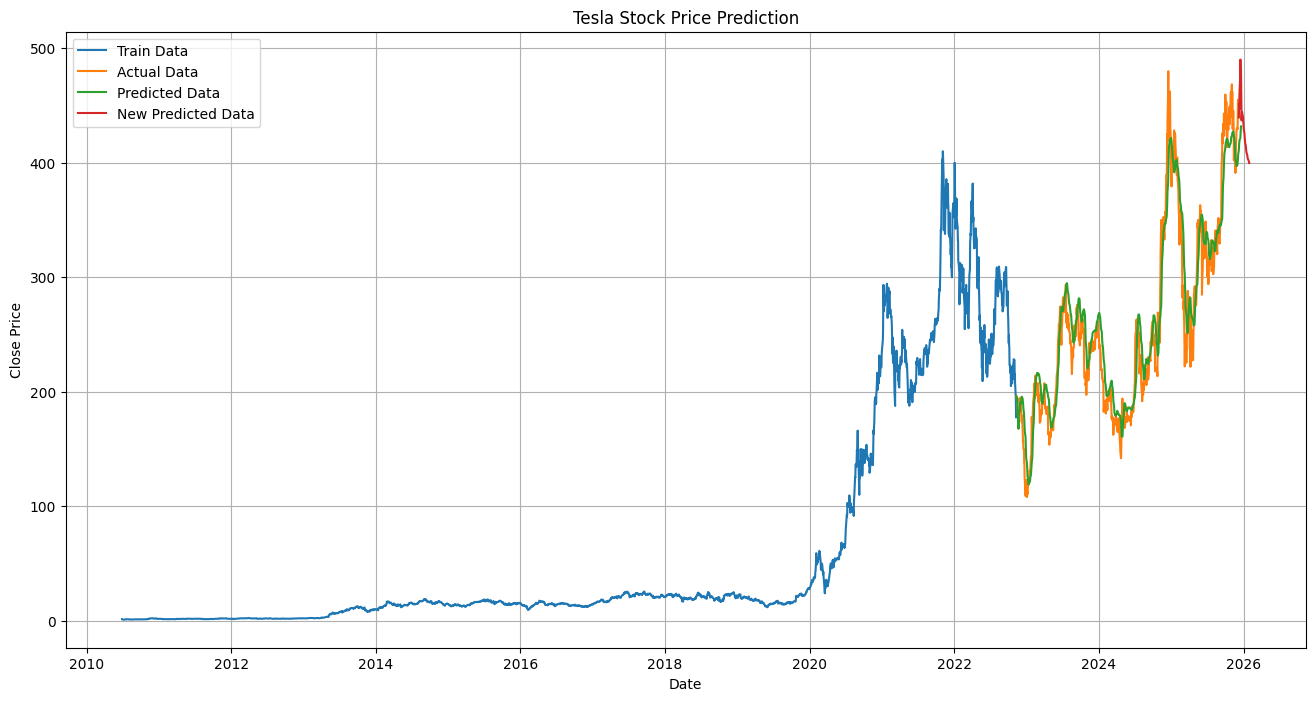

In [ ]:
plt.figure(figsize=(16, 8))
plt.title('Tesla Stock Price Prediction')
plt.plot(train['Close'], label='Train Data')
plt.plot(test['Close'], label='Actual Data')
plt.plot(test['preds'], label='Predicted Data')
plt.plot(test_pred['Close'], label='New Predicted Data')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid()
plt.legend()